In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("incl/")

import ELPH_dyn

import narrom

In [2]:
# trajectories = narrom.utils.load_trajectories(filename='/home/agluedge/Preprints/ELPH/runs/runs_n_kmax=200.npz')
trajectories = narrom.utils.load_trajectories(filename='../runs_n_kmax=80.npz')


# trajectories = trajectories[::10]

for k in range(len(trajectories)):
    trajectories[k] = trajectories[k].T

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)

1000 loaded with n_kmax = 80


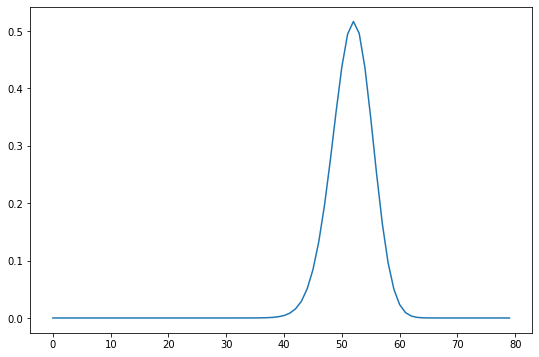

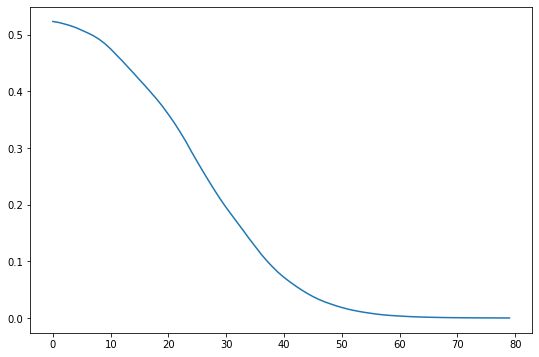

In [3]:
plt.plot(trajectories[1][0])
plt.show()

plt.plot(trajectories[1][-1])
plt.show()

In [7]:
class fermi_fit:
    def __init__(self, DOS, Energies):
        self.DOS = DOS
        self.Energies = Energies
        
        self.MAXERROR = 5E-12
        self.STEP_LIMIT = 2000  #// maximale Anzahl an Schritten für eine Berechnung
        self.dmu = 0.5E-3        #// differentieller Schritt zur Berechnung der Ableitungen d/dmu,d/dT
        self.dT = 1.
        self.mstep_max = 0.1  #// maximale Schrittweite der Iterationen
        self.Tstep_max = 500.

        
    def fermi(self,E,mu=1,T=1):
        return 1./(np.exp((E-mu)/(ELPH_dyn.kB*T)) + 1)
    
    #berechnet chem Pot. (eV) und Temperatur der Fermiverteilung
    #aus vorgegebener Ladungsträgerdichte + Gesamtenergie, Ausgabe in *mu, *temp
    #en_Bulk/QW/QD sind entweder Elektonen- oder Loch-Energien (werden durch Aufruf der jeweiligen calc_fermi_CP_e/h-Funktion gesetzt)
    def fit(self, state, mu_start, T_start, FERMI_DEBUG = False):

        dens = 0.
        en = 0.

        for i in range(state.size):
            #Gesamtdichte und -energie aufsummieren
            f = self.DOS[i] * state[i]
            dens += f   
            en += f * self.Energies[i]

    #     print(dens,en)


        m=mu_start
        T=T_start;

        m2 = m;
        T2 = T;
    #     steps = 0;
        d = 0
        d_dmu = 0
        d_dT = 0
        dDdmu = 0
        dDdT = 0;
        E = 0
        E_dmu = 0
        E_dT = 0
        dEdmu = 0
        dEdT = 0;
        f=0
        mstep=0
        Tstep=0

        Jacobi_Det = 0;
        deltaD = 0
        deltaE = 0
        for steps in range(self.STEP_LIMIT):
            d = d_dmu = d_dT = 0
            E = E_dmu = E_dT = 0
            #// resultierende Dichte + Energie aus Fermifunktion aufsummieren
            #// m2 = m+delta_m,
            #// Berechnung der Jacobi-Matrix von (Dichte, Energie) nach (mu, T)
            m2 = m+self.dmu
            T2 = T+self.dT

            for i in range(state.size):

                #Gesamtdichte und -energie aufsummieren
                f = self.DOS[i] * self.fermi(self.Energies[i], m, T)
                d += f   
                E += f * self.Energies[i]

                #Werte bei mu = mu+dmu
                f = self.DOS[i] * self.fermi(self.Energies[i], m2, T)
                d_dmu += f        
                E_dmu += f * self.Energies[i]

                #Werte bei T = T+dT
                f = self.DOS[i] * self.fermi(self.Energies[i], m, T2)
                d_dT += f        
                E_dT += f * self.Energies[i]

            # Genau genug -> fertig
            error = np.maximum( np.abs(d/dens-1.), np.abs(E/en-1.));
            if ( error <= self.MAXERROR ): 
    #             print('error: ', error)
                break

            #//Jacobi-Matrix-Elemente berechnen
            dDdmu = (d_dmu-d)/self.dmu
            dEdmu = (E_dmu-E)/self.dmu
            dDdT = (d_dT-d)/self.dT
            dEdT = (E_dT-E)/self.dT
            Jacobi_Det = dDdT*dEdmu-dDdmu*dEdT
            if (Jacobi_Det == 0):
                print("calc_fermi_CC_eh: Jacobi_Det wird null!!!")
                print("     d=",d,"  mu=",m,"  E=",E,"  T=",T)
                break

            #// Berechne neues mu,T durch Lösung von A.(deltaMu, deltaT) = (deltaD, deltaE). => Invertierung der Jacobimatrix gibt dmu,dT
            deltaD = dens-d
            deltaE = en-E
            mstep = (deltaE*dDdT-deltaD*dEdT)/Jacobi_Det
            Tstep = (deltaD*dEdmu-deltaE*dDdmu)/Jacobi_Det

            if(mstep < -self.mstep_max):
                mstep = -self.mstep_max
            elif (mstep > self.mstep_max):
                mstep = self.mstep_max;
            if(Tstep < -self.Tstep_max):
                Tstep = -self.Tstep_max
            elif (Tstep > self.Tstep_max):
                Tstep = self.Tstep_max

            m += mstep;
            T += Tstep;

            if FERMI_DEBUG:
                print("calc_fermi_CC_eh: dens=",d,", en=",en)
                print("calc_fermi_CC_eh: mu=",m,", T=",T," nach ",steps," Schritten")

        if (steps == self.STEP_LIMIT-1):
            print("calc_fermi_CC_eh braucht mehr als STEP_LIMIT Schritte!")
            print("calc_fermi_CC_eh: mu_start=",mu_start,",T_start=",T_start)
            print("calc_fermi_CC_eh: dens=",dens,", en=",en)
            print("calc_fermi_CC_eh: d=",d,", E=",E)
            print("calc_fermi_CC_eh: mu=",m,", T=",T)
            print("calc_fermi_CC_eh: error=",error," nach ",steps," Schritten")


        return m,T,steps

In [8]:
dk = 4./n_kmax

get_dispersion = ELPH_dyn.electron_dispersion
get_DOS = ELPH_dyn.electron_DOS

get_k = ELPH_dyn.get_k

ks = get_k(dk,np.arange(n_kmax))
DOS = get_DOS(ks,dk)
ens = get_dispersion(ks)

# print(DOS.shape, ens.shape)


fermi_fitter = fermi_fit(DOS,ens)

state density:  0.24009372296255527
qmu 0.21196967936174327 qTemp 1365.4924334802918 steps 6
qfermi density:  0.24009372296255546


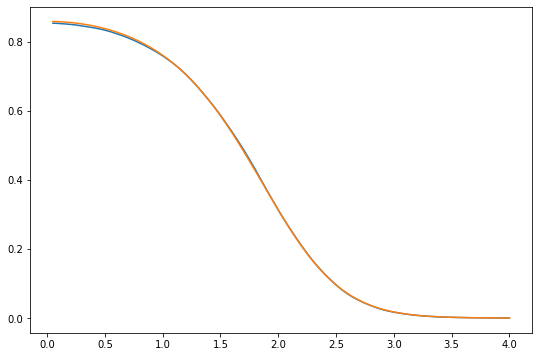

In [36]:

state = trajectories[10][-1]

print('state density: ', ELPH_dyn.get_density_from_state(state,dk))

mu,Temp,steps = fermi_fitter.fit(state, 0.1, 1000, False)

print('qmu',mu, 'qTemp',Temp,'steps',steps)


qfermi = fermi_fitter.fermi(ens,mu,Temp)

print('qfermi density: ', ELPH_dyn.get_density_from_state(qfermi,dk))

plt.plot(ks,state)
plt.plot(ks,qfermi)
plt.show()


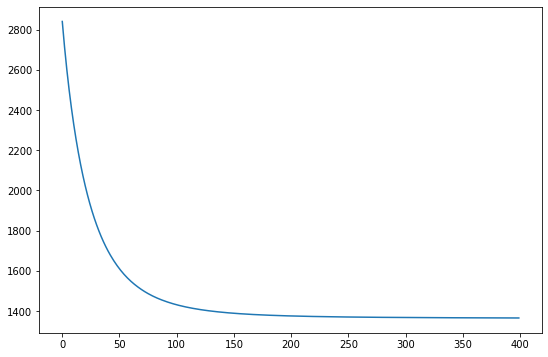

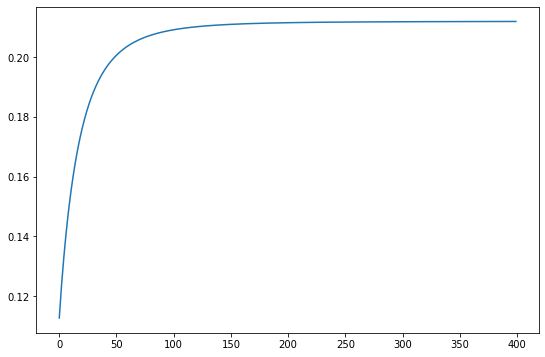

In [33]:
run = trajectories[10]
Temps = []
mus = []


for k in range(run.shape[0]):
    mu,Temp,steps = fermi_fitter.fit(run[k], 0.1, 1000, False)
    mus.append(mu)
    Temps.append(Temp)
    
plt.plot(Temps)
plt.show()

plt.plot(mus)
plt.show()